# Assignment -5 Feature importances for LGBM

In [1]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from datetime import timedelta
import lightgbm as lgbm
from sklearn.metrics import mean_squared_log_error as msle

In [2]:
data = pd.read_csv('final_data.csv')

In [3]:
# checking for the null values
data.isna().sum().sum()

0

In [4]:
# let's drop the columns that are not required (they were only used to create new features)
data = data.drop(columns= ['2_MONTH_BEFORE', '1_WEEK_BEFORE'])

In [5]:
data.WEEK_END_DATE = pd.to_datetime(data.WEEK_END_DATE)

In [6]:
data.head(10)

,WEEK_END_DATE,STORE_NUM,UPC,BASE_PRICE,FEATURE,DISPLAY,UNITS,MANUFACTURER_1,MANUFACTURER_2,MANUFACTURER_3,...,day,day_of_year,week,quarter,U_MANUFACTURER,U_CATEGORY,U_SUB_CATEGORY,UNITS_BEFORE_52WEEK,price_difference,AVERAGE_UNITS_IN_2_MONTH
0,2009-01-14,367,1111009477,1.57,0,0,13,1,0,0,...,14,14,3,1,4,3,5,0.0,0.0,0.0
1,2009-01-14,367,1111009497,1.39,0,0,20,1,0,0,...,14,14,3,1,4,3,5,0.0,0.0,0.0
2,2009-01-14,367,1111085319,1.88,0,0,14,1,0,0,...,14,14,3,1,4,3,5,0.0,0.0,0.0
3,2009-01-14,367,1111085345,1.88,0,0,29,1,0,0,...,14,14,3,1,4,3,5,0.0,0.0,0.0
4,2009-01-14,367,1111085350,1.98,0,0,35,1,0,0,...,14,14,3,1,4,3,5,0.0,0.0,0.0
5,2009-01-14,367,1111087395,3.94,0,1,50,1,0,0,...,14,14,3,1,4,3,5,0.0,0.0,0.0
6,2009-01-14,367,1111087396,4.00,0,1,61,1,0,0,...,14,14,3,1,4,3,5,0.0,0.0,0.0
7,2009-01-14,367,1111087398,4.00,0,1,72,1,0,0,...,14,14,3,1,4,3,5,0.0,0.0,0.0
8,2009-01-14,367,1600027527,3.19,0,0,12,0,1,0,...,14,14,3,1,4,3,5,0.0,0.0,0.0
9,2009-01-14,367,1600027528,4.59,0,0,31,0,1,0,...,14,14,3,1,4,3,5,0.0,0.0,0.0


In [7]:
week = data.WEEK_END_DATE.unique()

In [8]:
def validation_df(data, week, no_of_months, no_of_validation):
    
    model_set = []
    set_n = 1
    for w in range(len(week)-1,0,-1):
        x_data = {}

        x_data['train_start_1'] = week[w-3-4*no_of_months]
        x_data['train_end_1'] = week[w-4]
        x_data['train_start_2'] = week[w-1-4*no_of_months]
        x_data['validate_week'] = week[w-2]
        x_data['test_week'] = week[w]
        x_data['no_days_train_1'] = x_data['train_end_1'] - x_data['train_start_1']
        x_data['no_days_train_2'] = x_data['validate_week'] - x_data['train_start_2']
        x_data['set_no'] = 'set'+str(set_n)
        set_n +=1
        model_set.append(x_data)
        if(len(model_set) == no_of_validation):
            break
        

    df = pd.DataFrame.from_dict(model_set)
    df['no_days_train_1'] = df['no_days_train_1'] + timedelta(days=7)
    df['no_days_train_2'] = df['no_days_train_2'] + timedelta(days=7)
    return df    

In [9]:
validation_df(data, week, no_of_months=2, no_of_validation = 14)

,train_start_1,train_end_1,train_start_2,validate_week,test_week,no_days_train_1,no_days_train_2,set_no
0,2011-07-13,2011-08-31,2011-07-27,2011-09-14,2011-09-28,56 days,56 days,set1
1,2011-07-06,2011-08-24,2011-07-20,2011-09-07,2011-09-21,56 days,56 days,set2
2,2011-06-29,2011-08-17,2011-07-13,2011-08-31,2011-09-14,56 days,56 days,set3
3,2011-06-22,2011-08-10,2011-07-06,2011-08-24,2011-09-07,56 days,56 days,set4
4,2011-06-15,2011-08-03,2011-06-29,2011-08-17,2011-08-31,56 days,56 days,set5
5,2011-06-08,2011-07-27,2011-06-22,2011-08-10,2011-08-24,56 days,56 days,set6
6,2011-06-01,2011-07-20,2011-06-15,2011-08-03,2011-08-17,56 days,56 days,set7
7,2011-05-25,2011-07-13,2011-06-08,2011-07-27,2011-08-10,56 days,56 days,set8
8,2011-05-18,2011-07-06,2011-06-01,2011-07-20,2011-08-03,56 days,56 days,set9
9,2011-05-11,2011-06-29,2011-05-25,2011-07-13,2011-07-27,56 days,56 days,set10


In [10]:
def get_evaluation_sets(data, df):
    evaluation_set = []
    
    for row in range(df.shape[0]):
        print(df.loc[row]['set_no'])
        # get the train data 1
        train_data_1 = data[(data.WEEK_END_DATE >= df.loc[row]['train_start_1']) & (data.WEEK_END_DATE <= df.loc[row]['train_end_1'])]        
        # get the validate data
        validation_data = data[data.WEEK_END_DATE == df.loc[row]['validate_week']]
        # get the train data 2
        train_data_2 = data[(data.WEEK_END_DATE >= df.loc[row]['train_start_2']) & (data.WEEK_END_DATE <= df.loc[row]['validate_week'])]
        # get the test data
        test_data = data[data.WEEK_END_DATE == df.loc[row]['test_week']]
        evaluation_set.append((train_data_1, validation_data, train_data_2, test_data))
    return evaluation_set

In [11]:
evaluation_sets = get_evaluation_sets(data,
                                      validation_df(data,
                                                    week,
                                                    no_of_months= 2,
                                                    no_of_validation=14)
                                     )

set1
set2
set3
set4
set5
set6
set7
set8
set9
set10
set11
set12
set13
set14


In [12]:
def get_msle(true, predicted) :
    return np.sqrt(msle(true, predicted))

## Function to find the average rmsle for train and test sets

In [30]:
def get_results_on_evaluation_set(eval_set):
    train_scores = []
    test_scores = []
    for ev in eval_set:
        train_data_1, validate, train_data_2, test = ev

        train_data_x = train_data_2.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        train_data_y = train_data_2['UNITS']

        test_x = test.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        test_y = test['UNITS']

        d_train = lgbm.Dataset(train_data_x,train_data_y)
        d_val =   lgbm.Dataset(test_x,test_y)

        params = {
                'boosting_type':'gbdt',
                'objective': 'regression',
                'random_state': 0,
                'learning_rate':0.01,
                'n_estimators':350,
                'metric':'custom',
                'max_depth': 5,
                'min_child_samples': 120,
                'num_leaves': 125,
                'n_jobs':4,
                'subsample_freq': -1,
                'verbose': -1
                }

        model = lgbm.train(params=params, train_set=d_train, valid_sets=d_val)
        train_scores.append(get_msle(train_data_y,model.predict(train_data_x)))
        test_scores.append(get_msle(test_y,model.predict(test_x)))
        
        
    train_avg = np.mean(train_scores)
    test_avg = np.mean(test_scores)
    
    print("The mean rmsle for train set is: ", train_avg)
    print("The mean rmsle for test set is: ", test_avg)
    

In [31]:
get_results_on_evaluation_set(evaluation_sets)

The mean rmsle for train set is:  0.42842172314224947
The mean rmsle for test set is:  0.48290398451451727


## Function to find out the feature importances

In [32]:
# Let's use the hyperameters obtained from the previous assignment.
def get_feature_importance(eval_set):
    train_data_1, validate, train_data_2, test = eval_set
    
    train_data_x = train_data_2.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
    train_data_y = train_data_2['UNITS']
        
    test_x = test.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
    test_y = test['UNITS']
    
    d_train = lgbm.Dataset(train_data_x,train_data_y)
    d_val =   lgbm.Dataset(test_x,test_y)
    
    params = {
            'boosting_type':'gbdt',
            'objective': 'regression',
            'random_state': 0,
            'learning_rate':0.046,
            'n_estimators':350,
            'metric':'custom',
            'max_depth': 5,
            'min_child_samples': 120,
            'num_leaves': 125,
            'n_jobs':4,
            'subsample_freq': -1,
            'verbose': -1
            }
    
    model = lgbm.train(params=params, train_set=d_train, valid_sets=d_val)
    lgbm.plot_importance(model, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', xlabel='Feature importance', ylabel='Features', importance_type='auto', max_num_features=None, ignore_zero=True, figsize=None, dpi=None, grid=True, precision=3)

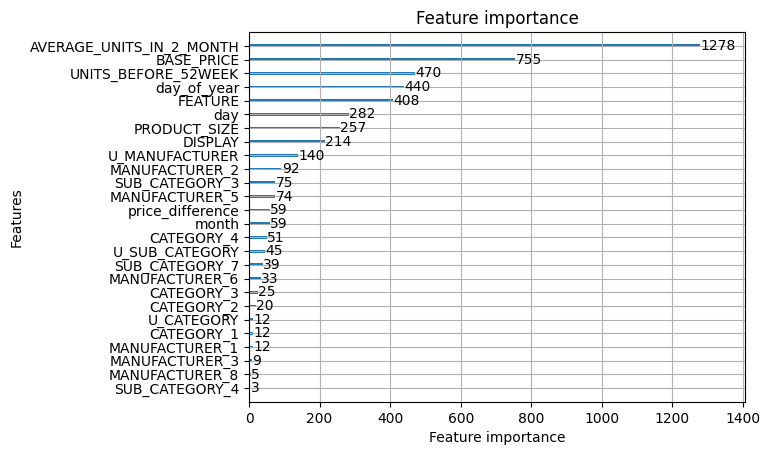

In [33]:
get_feature_importance(evaluation_sets[0])

Top 5 most important features are:

1. Average_units_in_2_months

2. Base_Price

3. Units_Before_52_week

4. day_of_year

5. feature